In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
#sys.path.append('/home/jma819/post_cmfe_analysis')
sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf
import scipy.spatial.distance as dist
import itertools
import math
import warnings
import csv
warnings.filterwarnings(action='once')

/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of 

In [2]:
reload(utils_jjm)
reload(dlc_utils)

<module 'dlc_utils' from '/home/jma819/post_cmfe_analysis/dlc_utils.py'>

In [3]:
cnmfe_file_key = pd.read_csv('/volumes/My_Passport/dlc_analysis/behavcamvideos/cnmfe_file_key.csv')
#cnmfe_file_key = pd.read_csv('/projects/p30771/dlc_analysis/openfield_dlc_output/cnmfe_file_key.csv')

In [4]:
cnmfe_base_dir = '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/'
#cnmfe_base_dir = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/'
wt_CNMFE_file = ['30-Mar_20_39_05_out.mat', '30-Mar_20_45_16_out.mat', '27-Feb_17_33_59_out.mat', '22-Mar_22_52_02_out.mat',
                 '28-Feb_16_10_05_out.mat', '27-Feb_17_32_15_out.mat', '28-Feb_16_21_21_out.mat', '25-Mar_13_27_27_out.mat',
                 '25-Mar_14_22_02_out.mat', '25-Mar_14_22_44_out.mat', '26-Mar_18_33_55_out.mat', '27-Mar_00_26_12_out.mat', '27-Mar_00_48_46_out.mat']

ko_CNMFE_files = ['31-Mar_13_28_15_out.mat', '29-Mar_21_42_20_out.mat', '13-Apr_17_57_40_out.mat', '29-Mar_14_27_55_out.mat', '13-Apr_16_01_20_out.mat',
                 '13-Apr_16_11_27_out.mat', '29-Mar_13_39_44_out.mat']

In [5]:
tracking_files = ['/volumes/My_Passport/dlc_analysis/behavcamvideos/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 
#tracking_files = ['/projects/p30771/dlc_analysis/openfield_dlc_output/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 

In [6]:
CNMFE_dir_paths_list = [str(cnmfe_base_dir+fname) for fname in wt_CNMFE_file]
#CNMFE_dir_paths_list

In [7]:
binning_time = 1 # seconds 
body_part_for_tracking = 'tail_base' #

grouped_raw_data = {}
success = []
failed = []
for CNMFE_file, tracking_file in zip(CNMFE_dir_paths_list, tracking_files):
    #print(CNMFE_file)
    #print(tracking_file)
    try:
        # load cell fluorescence 
        cell_fluorescence = sio.loadmat(CNMFE_file)
        C_timedelta = utils_jjm.create_fluorescence_time_delta(cell_fluorescence['C'])
        C_normalized = C_timedelta.apply(utils_jjm.normalize).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_z_scored = C_timedelta.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_normalized_z_scored = C_normalized.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_normalized)-1)*(1/20), len(C_normalized)), unit='s'), drop=True)
        # create tracking time deltas
        interpolated = utils_jjm.prepare_timedelta_dfs(tracking_file)
        #load spatial components by session
        com_df, spatial_components = utils_jjm.return_spatial_info(CNMFE_file, 0.6)
        cell_contours, for_dims = utils_jjm.create_contour_layouts(spatial_components)
        #C_z_scored_filtered = utils_jjm.filter_out_by_size(C_z_scored, cell_contours, for_dims, 0.6, 100)
        #store results 
        grouped_raw_data[tracking_file.split('/')[-2]] = {'C': C_timedelta, 'C_z_scored': C_z_scored, 'C_normalized': C_normalized, 'C_normalized_z_scored': C_normalized_z_scored, 
                                                          'interpolated' : interpolated, 'com' : com_df, 'spatial_components' : spatial_components, 'cell_contours': cell_contours,  
                                                         'for_dims' : for_dims}
        success.append((tracking_file.split('/')[-2], CNMFE_file.split('/')[-1]))
    except FileNotFoundError:
        failed.append(tracking_file)
    except OSError:
        failed.append(tracking_file)

## triggered averaging 

In [8]:
## combine dfs for each session to bin velocity values across dfs
#downsample
new_sampling_interval = .2
V_df = pd.concat([grouped_raw_data[session]['interpolated'].resample(str(new_sampling_interval)+'S').max() 
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))
all_sessions_v_bins = pd.cut(V_df['tail_base'], bins=150)

V_df['velocity_bins'] = all_sessions_v_bins

In [9]:
filtered_for_analysis = {}
for session in list(grouped_raw_data.keys()):
    filtered_for_analysis[session] = utils_jjm.filter_out_by_size(grouped_raw_data[session]['C_normalized_z_scored'], grouped_raw_data[session]['cell_contours'], 
                                                                  grouped_raw_data[session]['for_dims'], 0.6, 100)
C_df = pd.concat([filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))


In [10]:
#bin by activity threshold (body_part, resting_time_threshold, active_time_threshold, crossing_threshold, resting_threshold, activity_threshold)
binned_velocity_df = pd.DataFrame([dlc_utils.bin_by_activity_threshold(V_df.loc[session]['tail_base'], 80, 20, 1, 2, 3)
                                for session in list(grouped_raw_data.keys())], index=list(grouped_raw_data.keys()))
binned_velocity_df = binned_velocity_df.transpose()

In [11]:
#binned_velocity_df

In [12]:
#fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True)
#ax1.plot(binned_velocity_df['GRIN013_H13_M33_S54'].values)
#ax2.plot(V_df.loc['GRIN013_H13_M33_S54']['tail_base'].values)
#plt.show()

In [13]:
## get velocity threshold indicies and select fluorescence regions
triggered_activity_across_sessions = {}
for session in list(grouped_raw_data.keys()):
    #inputs activity_threshold, resting_threshold, resting_baseline 
    crossing_indicies = utils_jjm.select_trigger_regions(binned_velocity_df[session], 0.5, 0.5, 20)
    #inputs time_to_plot
    threshold_activity = utils_jjm.average_triggered_regions(V_df.loc[session]['tail_base'].values, crossing_indicies, 80)
    cells_in_session = C_df.loc[session].dropna(axis=1)
    cell_fluorescence = cells_in_session.drop(['msCamFrame'], axis=1)
    f_threshold_activity = utils_jjm.average_triggered_regions(cell_fluorescence.mean(axis=1).values, crossing_indicies, 80)
    triggered_activity_across_sessions[session] = pd.concat([threshold_activity, f_threshold_activity], axis=1, keys=['velocity', 'fluorescence'])

In [14]:

## get velocity threshold indicies and select fluorescence regions of individual cells
indiv_cell_activity_by_session = []
for session in list(grouped_raw_data.keys()):
    #inputs activity_threshold, resting_threshold, resting_baseline 
    crossing_indicies = utils_jjm.select_trigger_regions(binned_velocity_df[session], 0.5, 0.5, 20)
    #inputs time_to_plot
    samples_to_select = 80
    threshold_activity = utils_jjm.average_triggered_regions(V_df.loc[session]['tail_base'].values, crossing_indicies, samples_to_select)
    cells_in_session = C_df.loc[session].dropna(axis=1)
    cell_fluorescence = cells_in_session.drop(['msCamFrame'], axis=1)

    activity_at_crossing =[]
    for point in crossing_indicies:
        activity_at_crossing.append(cell_fluorescence.iloc[2042-samples_to_select:2042+samples_to_select].reset_index(drop=True))
    indiv_cell_activity_by_session.append(pd.concat(activity_at_crossing, axis=1, keys=crossing_indicies))
    
triggered_activity_across_cells = pd.concat(indiv_cell_activity_by_session, axis=1, keys=grouped_raw_data.keys())    


# triggered_activity_across_sessions

In [15]:
#concat by mouse 
concacted_by_mouse = {}
for mouse in list(set([session[0:7] for session in list(triggered_activity_across_sessions.keys())])):
    dfs_by_mouse = []
    sessions = []
    for session in list(triggered_activity_across_sessions.keys()):
        if mouse in session:
            if not(triggered_activity_across_sessions[session].empty):
                means = triggered_activity_across_sessions[session].mean(axis=1, level=0)
                dfs_by_mouse.append(means)
                sessions.append(session)
    if len(dfs_by_mouse)>0:
        concacted_by_mouse[mouse] = pd.concat(dfs_by_mouse, axis=1, keys=sessions)
combined_by_mouse = pd.concat(list(concacted_by_mouse.values()), axis=1, keys=list(concacted_by_mouse.keys()))

In [16]:
combined_by_mouse_timedelta = combined_by_mouse.set_index(pd.to_timedelta(np.linspace(0, (len(combined_by_mouse)-1)*(1/5), len(combined_by_mouse)), unit='s'), drop=True)
resampled_for_plotting = combined_by_mouse_timedelta.resample('.2S').mean()

In [17]:
#resampled_for_plotting.head()

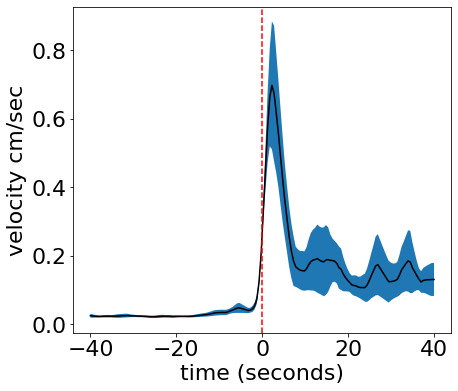

In [19]:
plt.rcParams.update({'font.size': 22})
df_to_plot = resampled_for_plotting
activity_measure = 'spatial_coordination'
x = np.linspace(-(len(df_to_plot)/2)*.5, (len(df_to_plot)/2)*.5, len(df_to_plot))
scale_f = 0.0868
mean=df_to_plot.mean(axis=1, level=2)['velocity'].values*scale_f
plt.plot(x, df_to_plot.mean(axis=1, level=2)['velocity'].values*scale_f, color='k')
std_error = ((df_to_plot.std(axis=1, level=2)['velocity'])/math.sqrt(df_to_plot.mean(axis=1, level=0).shape[1]))*scale_f
plt.fill_between(x, mean-std_error, mean+std_error)
ax = plt.gca()
ax.set_ylabel('velocity cm/sec')
ax.set_xlabel('time (seconds)')
ax.axvline(x=(0), linestyle='--', color='r')
fig = plt.gcf()
fig.set_size_inches(7, 6)
#fig.draw()
#fig.savefig('/home/jma819/presentation_files/wt_velocity_spatial_coord_triggered.svg', transparent=True)
fig.subplots_adjust(left=0.15)
#fig.savefig('/home/jma819/presentation_files/v_triggered.pdf', transparent=True)
plt.show()

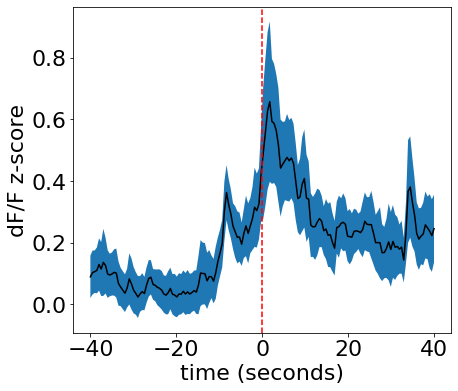

In [20]:
activity_measure = 'fluorescence'
x = np.linspace(-(len(df_to_plot)/2)*.5, (len(df_to_plot)/2)*.5, len(df_to_plot))
mean = df_to_plot.mean(axis=1, level=2)[activity_measure].values
plt.plot(x, mean, color='k')
std_error = (df_to_plot.std(axis=1, level=2)[activity_measure])/math.sqrt(df_to_plot.mean(axis=1, level=0).shape[1]*1)
plt.fill_between(x, mean-std_error, mean+std_error)
ax = plt.gca()
ax.set_ylabel('dF/F z-score')
ax.set_xlabel('time (seconds)')
ax.axvline(x=0, linestyle='--', color='r')
fig = plt.gcf()
fig.set_size_inches(7, 6)
#fig.draw()
#fig.savefig('.svg')
fig.subplots_adjust(left=0.15)
#fig.savefig('/home/jma819/presentation_files/wt_fluorescence_triggered.pdf', transparent=True)
plt.show()

## select subset of cells active during movement initiation and plot v correlations 

In [81]:
## look at individual cells 
#plt.plot(triggered_activity_across_cells['GRIN013_H13_M33_S54'][2042][4].values)
#ax = plt.gca()
#ax.axvline(x=80, linestyle='--', color='r')
#ax.axhline(y=2, linestyle='--', color='r')
#plt.show()

In [82]:
#plt.plot(triggered_activity_across_cells.mean(axis=1))
#plt.show()


In [23]:
active_threshold = 2
testing_limits_samples = (70, 80)
test_region = pd.DataFrame(triggered_activity_across_cells.iloc[testing_limits_samples[0]:testing_limits_samples[1]]>active_threshold)

In [24]:
cells_active_before_crossing = [test_region.any().index[cell] for cell in range(len(triggered_activity_across_cells.columns)) if test_region.any()[cell]==True]

In [26]:
active_cells = list(set([(index[0], index[2]) for index in cells_active_before_crossing]))

In [27]:
len(active_cells)

72

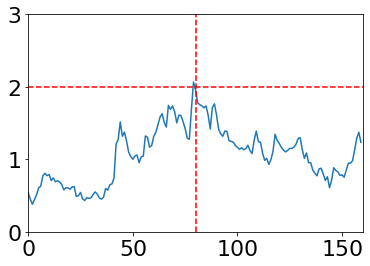

In [28]:
plt.plot(triggered_activity_across_cells[cells_active_before_crossing].mean(axis=1))
ax = plt.gca()
ax.axvline(x=80, linestyle='--', color='r')
ax.axhline(y=2, linestyle='--', color='r')
ax.set_xlim([0, 160])
ax.set_ylim([-0, 3])
plt.show()

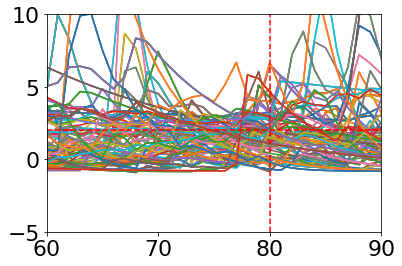

In [29]:
plt.plot(triggered_activity_across_cells[cells_active_before_crossing])
ax = plt.gca()
ax.axvline(x=80, linestyle='--', color='r')
ax.axhline(y=2, linestyle='--', color='r')
ax.set_xlim([60, 90])
ax.set_ylim([-5, 10])
plt.show()

In [31]:
## reconstruct videos of active cells

In [32]:
active_cell_dictionary = {}
for session in list(set([cell[0] for cell in active_cells])):
    active_cell_dictionary[session]=[]
for cell in active_cells:
    active_cell_dictionary[cell[0]].append(cell[1])
    

In [32]:
# save dictionary to file for loading later 
active_cell_dictionary
dictionary_output = csv.writer(open('/projects/p30771/miniscope/analysis/OpenFieldAnalysis/indiv_cell_regressions/movement_initiation.csv', 'w'))
for key, val in active_cell_dictionary.items():
    dictionary_output.writerow([key, val])

# look at firing properties of movement initiating cells across velocity bins 

In [48]:
## recombine just active cells 
session_cells = {}
for session in list(active_cell_dictionary.keys()):
    session_cells[session] = C_df.loc[session][active_cell_dictionary[session]]

In [49]:
C_df_active_cells = pd.concat(session_cells)

# do binning by velocity on just the active cells, resample to smooth noise 

In [67]:
# combine dfs for each session to bin velocity values across dfs
#downsample
new_sampling_interval = 2
V_df = pd.concat([grouped_raw_data[session]['interpolated'].resample(str(new_sampling_interval)+'S').max() 
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))
all_sessions_v_bins = pd.cut(V_df['tail_base'], bins=50)

V_df['velocity_bins'] = all_sessions_v_bins

In [68]:
C_df_active_cells_resampled = pd.concat([C_df_active_cells.loc[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(list(session_cells.keys()))], keys=list(session_cells.keys()))

In [69]:
C_df_active_cells_resampled['velocity_bins'] = all_sessions_v_bins

In [71]:
by_cells_across_sessions = {}
for session in list(active_cell_dictionary.keys()):
    binned_regions = [C_df_active_cells_resampled.loc[session][C_df_active_cells_resampled.loc[session]['velocity_bins']==v_bin].drop(['velocity_bins'], axis=1).mean(axis=0).dropna() for
                  v_bin in all_sessions_v_bins.values.categories.values]
    cells_by_session_binned = pd.DataFrame(binned_regions, index=all_sessions_v_bins.values.categories.values)
    per_cell_regressions = dlc_utils.create_regression_models_per_cell(cells_by_session_binned, 2)
    by_cells_across_sessions[session] = per_cell_regressions

/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  


In [72]:
#get the velocity bin where cell fired most
max_bins = []
for session in list(by_cells_across_sessions.keys()):
    for cell in list(by_cells_across_sessions[session].keys()):
        max_bins.append(pd.DataFrame({(session,cell): by_cells_across_sessions[session][cell]['fit_df'].iloc[by_cells_across_sessions[session][cell]['fit_df']['y'].argmax()]}))
        #max_bins.append(by_cells_across_sessions[session][cell]['fit_df'].max(axis=0))

max_bins = pd.concat(max_bins, axis=1).transpose()

In [74]:
#for resetting index to cm/sec velocity 
binning_range = pd.interval_range(start=-1*0.0868, end=50*0.0868, periods=50)
end_points = {k:v for k,v in zip(np.linspace(1, 50, 50), [binning_range.values[interval].right for interval in range(len(binning_range))])}

max_bins['cm_sec'] = [end_points[max_bins['x'].values[point]] for point in range(len(max_bins['x'].values))]
max_bins = max_bins.transpose()

max_bins 

GRIN034_H15_M28_S2                     GRIN035_H13_M31_S20             \
                       19        5         2                   5          4    
y                1.538366  0.702984  1.500575            4.224487  13.039009   
x                2.000000  1.000000  2.000000           12.000000  24.000000   
cm_sec           0.090272  0.001736  0.090272            0.975632   2.038064   

                                                              ...  \
               29         36         25         7         76  ...   
y        2.340835  10.297975   1.445677   8.631067  1.771460  ...   
x       12.000000  24.000000  12.000000  11.000000  6.000000  ...   
cm_sec   0.975632   2.038064   0.975632   0.887096  0.444416  ...   

       GRIN013_H13_M33_S54                                              \
                        2          4          7          10         17   
y                 3.006032   2.670341   4.793069   5.095806   6.189139   
x                12.000000  13.000000  13.000000  24.000000  13.000000   
cm_sec            0.975632   1.064168   1.064168   2.038064   1.064168   

                                                               
               16         15         21         22         31  
y       20.715787   6.546151   3.042360  19.941253   3.428349  
x       24.000000  24.000000  13.000000  24.000000  10.000000  
cm_sec   2.038064   2.038064   1.064168   2.038064   0.798560  

[3 rows x 72 columns]

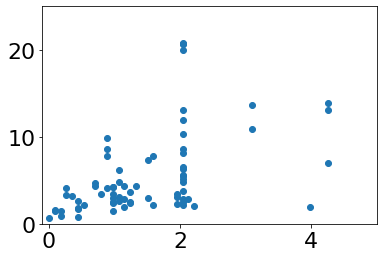

In [80]:
# distribution of all df versus velocity values 
plt.scatter(max_bins.loc['cm_sec'].values, max_bins.loc['y'].values)
plt.xlim((-.1, 5))
plt.ylim((0, 25))
plt.show()